#  Homework 1

In [1]:
import numpy as np
import urllib.request
import gzip
import shutil
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')


Code to Download data

In [2]:
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz','train-images-idx3-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz','train-labels-idx1-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz','t10k-images-idx3-ubyte.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz','t10k-labels-idx1-ubyte.gz')



('t10k-labels-idx1-ubyte.gz', <http.client.HTTPMessage at 0x15140c4ab20>)


Functions to preprocess labels and images




In [9]:
def get_images(fname):
    with gzip.open(fname) as f:
        np_images = np.frombuffer(f.read(), 'B', offset=16)
        np_images = np_images.reshape(-1, 784).astype('float32')
        np_images = np_images/255
        np_images = np_images - np.mean(np_images)
    return np_images
    

def get_labels(fname):
    with gzip.open(fname) as f:
        np_labels = np.frombuffer(f.read(), 'B', offset=8)
        print(np_labels)
        rows = len(np_labels)
        col = np_labels.max() + 1
        np_enc = np.zeros((rows, col), dtype='uint8')
        np_enc[np.arange(rows), np_labels] = 1
        print(np_enc.shape,np_enc)
    return np_enc

In [10]:
train_images = get_images('train-images-idx3-ubyte.gz')
train_labels = get_labels('train-labels-idx1-ubyte.gz')
test_images = get_images('t10k-images-idx3-ubyte.gz')
test_labels = get_labels('t10k-labels-idx1-ubyte.gz')


[5 0 4 ... 5 6 8]
(60000, 10) [[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
[7 2 1 ... 4 5 6]
(10000, 10) [[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
def addones(X):
    ones = np.ones((X.shape[0],1))
    ones = ones.flatten()
    return np.insert(X, 1, ones, axis=1)

def accuracy(X,Y,w):
    
    f = np.matmul(addones(X),w.T)
    f = np.argmax(f, axis=1)
    Y = np.argmax(Y, axis=1)
    return np.mean(Y==f)


def sgd(X, Y, itr, batch_size, lr, plot_f=False, sample_s = 1000):
    
    start_time = time.time()
    
    
    X = addones(X)
    m = X.shape[0]
    W = np.zeros((Y.shape[1],X.shape[1]))
    
    loss_lst, accuracy_lst = [], []
    
#     taking equally spaced indices from itr to calculate loss which is computationally expensive
    loss_ind = np.linspace(2,sample_s,50,dtype=int)
    
        
    for i in range(itr+1):
        select_indices = np.random.choice(np.arange(m), size = batch_size)
        lx = X[select_indices]        
        ly = Y[select_indices]

        grad_mat = ly - np.matmul(lx, W.T)
        grad_mat = -1 * np.matmul(grad_mat.T, lx)/batch_size
        
        W = W - lr*grad_mat
        
        if plot_f and (i in loss_ind):
            loss_lst.append((1/2)*(np.sum((Y - np.matmul(X, W.T)) **2)))
            accuracy_lst.append(accuracy(test_images, test_labels,W))
            
    end_time = time.time()           
            
    if plot_f:       
        
        fig,axs = plt.subplots(1,2,figsize=(15,5))

        axs[0].set_title("Training Loss vs Iterations for batch size " + str(batch_size))
        axs[0].set_ylabel("Training Loss")
        axs[0].set_xlabel("Iterations")
        axs[0].plot(list(loss_ind),loss_lst)

        axs[1].set_title("Accuracy vs Iterations for batch size " + str(batch_size))
        axs[1].set_ylabel("Accuracy")
        axs[1].set_xlabel("Iterations")
        axs[1].plot(list(loss_ind),accuracy_lst)

        return loss_lst, accuracy_lst
    
    
    return W, end_time-start_time
        

The below 2 cells are creating to test if grader wants to try different values, please uncomment those to playaround

In [15]:

# lw,_ = sgd(train_images, train_labels, 1000, 100, 0.01)


In [16]:
# tre = accuracy(train_images, train_labels, lw)
# te = accuracy(test_images, test_labels, lw)
# print("training accuracy ",tre)
# print("testing accuracy ",te)

training accuracy  0.85245
testing accuracy  0.8606


In [18]:

# Function to get the best learning rate amongst the one chosen below


def get_best_learning_rate(batch_size):
    
    learning_rate_arr = [1e-4, 1e-3, 1e-2, 1e-1]
    train_acc = np.zeros(len(learning_rate_arr))
    test_acc = np.zeros(len(learning_rate_arr))
    training_time = np.zeros(len(learning_rate_arr))

    for i,l in enumerate(learning_rate_arr):
        learned_weight, training_time[i]  = sgd(train_images, train_labels, 20000, batch_size, l)
        train_acc[i] = accuracy(train_images, train_labels, learned_weight)
        test_acc[i] = accuracy(test_images, test_labels, learned_weight)

    besti = np.argmax(test_acc)    
    return learning_rate_arr[besti], training_time[besti], test_acc[besti]

In [19]:
batch_lst = [1,10,100,1000]
best_lr = []
for j in range(len(batch_lst)):
    blr, best_time, best_acc = get_best_learning_rate(batch_lst[j])
    best_lr.append(blr)
    print('\n best lambda value for batch size ', batch_lst[j] ,'is ', best_lr[j], 'with training time ', best_time, 'accuracy' , best_acc )


 best lambda value for batch size  1 is  0.001 with training time  2.6262123584747314 accuracy 0.8565

 best lambda value for batch size  10 is  0.001 with training time  3.3580803871154785 accuracy 0.8622

 best lambda value for batch size  100 is  0.001 with training time  15.399561643600464 accuracy 0.8645

 best lambda value for batch size  1000 is  0.001 with training time  177.19412064552307 accuracy 0.8641


KeyboardInterrupt: 

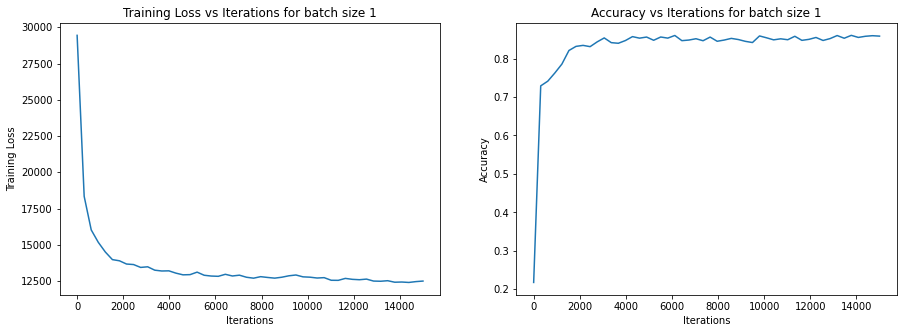

In [20]:

#Running the below snippet will train the model with best learning rate and plot the loss and accuracy graphs

sample_size = [15000,10000,8000, 7000]
for i in range(len(batch_lst)):
    sgd(train_images, train_labels, 20000, batch_lst[i], best_lr[i], True, sample_size[i])

In [ ]:
# Function for variable data set sizes


def variable_dataset(X,Y):
    
    N = [100, 500, 1000, 10000,50000,60000]
    m = X.shape[0]
    b_lr =0.001
    for ds in N:
        ds_indices = np.random.choice(np.arange(m), size = ds, replace = False)
        ds_x = X[ds_indices]        
        ds_y = Y[ds_indices]
        _,acc_lst = sgd(ds_x, ds_y, 20000, 100, b_lr, True, 8000)
        print('max accuracy for data size ', ds, ' is: ', max(acc_lst))

In [ ]:
variable_dataset(train_images,train_labels)

In [58]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import torch.nn as nn
import torch.nn.functional as F

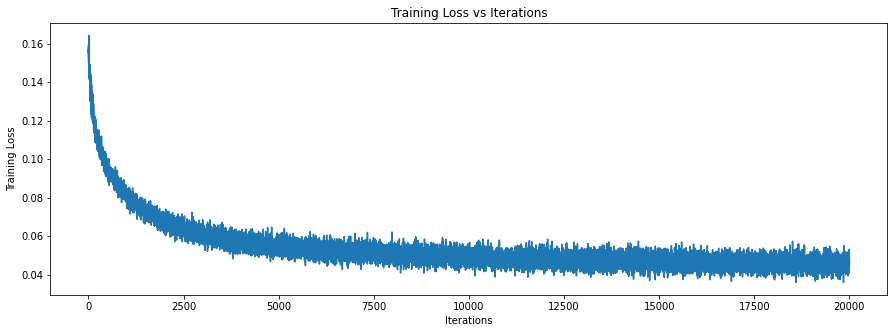

In [75]:
batch_size, t_lr, t_loss_lst, t_acc_lst = 100, 0.001, [], []

inputs = torch.from_numpy(train_images)
targets = torch.from_numpy(train_labels)
out_i = torch.from_numpy(test_labels)
dataset = TensorDataset(inputs, targets)
sp = RandomSampler(train_images, replacement = True, num_samples = 200)
train_loader = DataLoader(dataset = dataset, batch_size=batch_size, sampler = sp)

model = nn.Linear(784,10)

optimizer = torch.optim.SGD(model.parameters(), lr=t_lr)
criterion = nn.MSELoss()

t_loss_ind = np.linspace(2,10000,50,dtype=int)

it=0
for i in range(10000):
    for x,y in train_loader:
        
        it +=1
        optimizer.zero_grad()
        y_pred = model(x.float())
#         if i in t_loss_ind:
        loss = criterion(y_pred, y.float())
        loss.backward()
        

        t_loss_lst.append(float(loss))
#         out_Y_pred = model(out_i.float())
#         t_acc_lst.append()
        optimizer.step()

# print(len(t_loss_lst), len(t_loss_ind),it)
t_loss_ind = np.linspace(2,it,len(t_loss_lst),dtype=int)
fig,axs = plt.subplots(1,figsize=(15,5))

axs.set_title("Training Loss vs Iterations")
axs.set_ylabel("Training Loss")
axs.set_xlabel("Iterations")
axs.plot(list(t_loss_ind),t_loss_lst)  

In [ ]:
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=32)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
model.fc = nn.Linear(512, 10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch_loss = []
torch_acc = []
ITR = 2000
for i in range(2000):
    for data in dataloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.float())
        if (i+1)%(ITR/10) == 0:
            print(loss.float())
            torch_loss.append(float(loss))
            acc = accuracy(model(x_test.float()).detach().numpy(), y_test.detach().numpy())
            torch_acc.append(acc)
            print(acc)
        loss.backward()
        optimizer.step()